In [1]:
%matplotlib inline
import time
import numpy as np
np.set_printoptions(formatter={'float': lambda x: format(x, '.4e')})
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits import mplot3d
from datetime import datetime

## Objective function

Consider the Rosenbrock function

In [2]:
def rose_fun(x):
    x = np.asarray(x)
    r = 0.
    for i in range(len(x)-1):
        r += 100*(x[i+1]-x[i]**2)**2 + (1-x[i])**2
    return r

def rose_dfun(x):
    x = np.asarray(x)
    df = np.zeros_like(x)
    for i in range(len(x)-1):
        df[i] += -400*(x[i+1]*x[i]-x[i]**3) - 2*(1-x[i])
        df[i+1] += 200*(x[i+1]-x[i]**2)
    return df

def rose(x):
    return rose_fun(x), rose_dfun(x)

## Visualize the objective function

Text(0.5, 0.92, 'rose_fun')

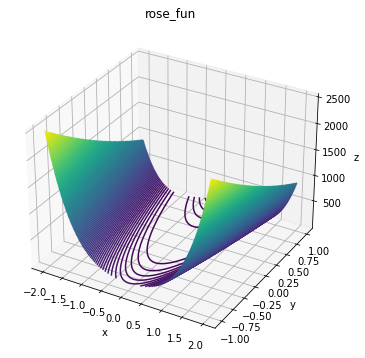

In [3]:
# this f is the name of savefig as well
f = rose_fun

# the boundary for testing
b_x = np.linspace(-2, 2, 100) 
b_y = np.linspace(-1, 1, 100)

X, Y = np.meshgrid(b_x, b_y)
# Or, change np.array as torch.tensor
Z = f(np.array([X, Y]))

fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 150, cmap='viridis')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('{}'.format(f.__name__))

## GD, AEGD

In [4]:
def gdm(k, x, v, r, func, p):
    dt = p['dt']
    m = p['m']
    f, df = func(x)
    _v = m*v + df
    _x = x - dt*_v
    return f, _x, _v, r, df

def aegd(k, x, v, r, func, p):
    dt = p['dt']
    c = p['c']
    m = p['m']
    
    f, df = func(x)
    dg = df / (2*np.sqrt(f+c))
    
    _v = m*v + (1-m)*dg
    _r = r / (1+2*dt*_v**2)
    _x = x - 2*dt*_r*_v

    return f, _x, _v, _r, df

In [5]:
def aagd_m(func, xs, Gs, p, k):
    # func: [f(x), df(x)]
    # xs = [x(0), x(1), ..., x(k)]
    # Gs = [x(k-m)-eta*df(k-m), ..., x(k-1)-eta*df(k-1)] 
    # k: the current step
    # default seting: p[online = True, eta=1e-4, m=2, beta=1, gap=100, maxiter=2000, tol=1e-5]
    
    eta = p['eta']
    beta = p['beta']
    m = p['m'] # the length of the window
    Xs, x = xs[-m-1:-1], xs[-1]
    # Xs = [x(k-m), ..., x(k-1)] # x0
    # x = x(k) x1
    
    Xs = np.asarray(Xs, dtype=np.float32)
    Gs = np.asarray(Gs, dtype=np.float32)
    
    Gk = x - eta * func(x)[1] # G1
    _x = Gk # x2
    

    freq = m if p['online'] else 1
    if k % freq == 0:
      Fs = Gs - Xs # Fs = [-eta*df(k-m), ..., -eta*df(k-1)] 
      Fk = Gk - x # F1
      # using QR decomposition to solve the least-square problem
      # [df(k)-df(k-m), ..., df(k)-df(k-1)] * theta = df(k)
      # refer Wikipedia/Anderson acceleration
      theta = np.linalg.lstsq((Fk - Fs).T, Fk, rcond=None)[0]
      x_ext = (1-beta) * (x + theta @ (Xs-x)) + beta * (Gk + theta @ (Gs-Gk))
      _x = x_ext
    
    return _x, Gk

In [6]:
def aaegd_m(func, xs, Gs, r, p, k):
    # func: [f(x), df(x)]
    # xs = [x(0), x(1), ..., x(k)]
    # Gs = [x(k-m)-eta*df(k-m), ..., x(k-1)-eta*df(k-1)] 
    # k: the current step
    # default seting: p[online = True, eta=1e-4, m=2, beta=1, gap=100, maxiter=2000, tol=1e-5]
    
    eta = p['eta']
    beta = p['beta']
    m = p['m'] # the length of the window
    Xs, x = xs[-m-1:-1], xs[-1]
    # Xs = [x(k-m), ..., x(k-1)] # x0
    # x = x(k) x1
    
    Xs = np.asarray(Xs, dtype=np.float32)
    Gs = np.asarray(Gs, dtype=np.float32)
    
    # AEGD, c=1
    v = func(x)[1] / (2*np.sqrt(func(x)[0] + 1))
    _r = r / (1 + 2*eta * v**2)
    Gk = x - 2*eta * _r * v  # G1
    _x = Gk # x2
    

    freq = m if p['online'] else 1
    if k % freq == 0:
      Fs = Gs - Xs # Fs = [-eta*df(k-m), ..., -eta*df(k-1)] 
      Fk = Gk - x # F1
      # using QR decomposition to solve the least-square problem
      # [df(k)-df(k-m), ..., df(k)-df(k-1)] * theta = df(k)
      # refer Wikipedia/Anderson acceleration
      theta = np.linalg.lstsq((Fk - Fs).T, Fk, rcond=None)[0]
      x_ext = (1-beta) * (x + theta @ (Xs-x)) + beta * (Gk + theta @ (Gs-Gk))
      _x = x_ext
    
    return _x, Gk, _r

## runners

In [7]:
def runner(x0, func, optim, p):
    t = time.time()
    
    # initialization
    if optim != aegd:
        r0 = np.zeros_like(x0)
    else: #AEGD
        r0 = np.sqrt(func(x0)[0]+1) * np.ones_like(x0)

    res = dict(fs=[func(x0)[0]], xs=[x0+1e-2], rs=[r0], vs=[0], Gs=[], Fts=[])
    fs, xs, rs, vs, Gs, Fts= res['fs'], res['xs'], res['rs'], res['vs'], res['Gs'], res['Fts']
    
    k = 1
    xs.append(x0)
    
    
    while np.linalg.norm(xs[-1]-xs[-2]) > p['tol']*(1+np.linalg.norm(xs[-2])) and k < p['maxiter']:
        f, x, v, r, grad = optim(k, xs[-1], vs[-1], rs[-1], func, p)
        fs.append(f)
        xs.append(x)
        rs.append(r)
        vs.append(v)

        if k % p['gap'] == 0:
            print('[{:4}], f: {:.4e}, grad: {}'.format(k, f, grad[:2]))
        k += 1
    
    elapsed = time.time() - t
    print('------------------')
    print('iterations: {}'.format(k-1))
    print('solution time: {:.4f}s'.format(elapsed))
    print('current function value: {}'.format(fs[-1]))
    print('current parameter value: {}'.format(xs[-1][:2]))
        
    return res, p, elapsed

In [8]:
def runner_on(func, x0, optim, p):
    t = time.time()
    
    f, df = func(x0)

    # initialization
    if optim != aaegd_m:
        # AA-GD_m
        res = dict(fs=[f], Gs=[x0 - p['eta'] * (df)], xs=[x0, x0 - p['eta'] * (df)]) 
        fs, Gs, xs = res['fs'], res['Gs'], res['xs']
    else: # AA-AEGD_m
        r0 = np.sqrt(f+1) * np.ones_like(x0)
        # v1 = df / (2*np.sqrt(f+1))
        # r1 = r0 / (1 + 2*p['eta'] * v1**2)
        # x1 = x0 - 2*p['eta'] * r1 * v1

        res = dict(fs=[f], Gs=[x0], xs=[x0+1e-2, x0], rs=[r0]) 
        fs, Gs, xs, rs = res['fs'], res['Gs'], res['xs'], res['rs']
    
    k = 1
    while np.linalg.norm(xs[-1]-xs[-2]) > p['tol']*(1+np.linalg.norm(xs[-2])) and k < p['maxiter']:
    #while abs(fs[-1]-1) > p['tol'] and k < p['maxiter']: 

        if optim != aaegd_m:
            # AAGD_m
            # compute x(k+1)
            x, Gk = optim(func, xs, Gs, p, k) 
            # Update xs, Gs
            if k >= p['m']:
                #xs = xs[1:]
                Gs = Gs[1:]

        else: # AA-AEGD_m
            # compute x(k+1)
            x, Gk, r = optim(func, xs, Gs, rs[-1], p, k) 
            # Update xs, Gs
            if k >= p['m']:
                #xs = xs[1:]
                Gs = Gs[1:]
            rs[-1] = r #

        xs.append(x) # 
        Gs.append(Gk) # 
        f, df = func(x)
        fs.append(f)

        if k % p['gap'] == 0:
            print('[{:}], f: {:.4e}, |df|:{:.4e}'.format(k, f, np.linalg.norm(df)))
        k += 1
    
    elapsed = time.time() - t
    print('------------------')
    print('iterations: {}'.format(k))
    print('solution time: {:.4f}s'.format(elapsed))
    print('current function value: {}'.format(fs[-1]))
    print('current parameter value: {}'.format(xs[-1][:2]))
        
    return res


## 2-D

In [9]:
x0_2 = np.array([1.5,-0.5]) #np.ones(2)
f_r2 = rose

In [10]:
iter_aagd_m_2 = []
for m in range(1,16):
    aagd_m_2 = runner_on(func=f_r2, x0=x0_2, optim=aagd_m, 
                        p=dict(online = True, eta=1.9e-4, m=m, beta=1, gap=100, maxiter=10000, tol=1e-6))
    iter_aagd_m_2.append(len(aagd_m_2['xs'])-1)

[100], f: 1.9700e-01, |df|:5.9292e-01
[200], f: 8.2977e-02, |df|:3.3067e-01
[300], f: 3.3241e-02, |df|:1.9003e-01
[400], f: 1.1344e-02, |df|:1.0448e-01
[500], f: 2.3403e-03, |df|:4.8331e-02
[600], f: 3.1522e-05, |df|:5.0404e-03
------------------
iterations: 601
solution time: 0.0280s
current function value: 3.152218652785259e-05
current parameter value: [9.9439e-01 9.8879e-01]
------------------
iterations: 76
solution time: 0.0027s
current function value: 2.0943463430070958e-07
current parameter value: [1.0005e+00 1.0009e+00]
------------------
iterations: 74
solution time: 0.0026s
current function value: 3.109552020393467e-08
current parameter value: [9.9985e-01 9.9970e-01]
------------------
iterations: 58
solution time: 0.0020s
current function value: 2.3688800995213775e-08
current parameter value: [9.9985e-01 9.9969e-01]
[100], f: 6.1278e-02, |df|:6.6094e-01
------------------
iterations: 137
solution time: 0.0044s
current function value: 1.9578458999310996e-06
current parameter 

In [11]:
iter_aaegd_m_2 = []
for m in range(1,16):
    aaegd_m_2 = runner_on(func=f_r2, x0=x0_2, optim=aaegd_m, 
                        p=dict(online = True, eta=6.4e-3, m=m, beta=1, gap=100, maxiter=10000, tol=1e-6))
    iter_aaegd_m_2.append(len(aaegd_m_2['xs'])-1)

------------------
iterations: 48
solution time: 0.0033s
current function value: 7309.835414556555
current parameter value: [3.0485e+00 7.4634e-01]
------------------
iterations: 20
solution time: 0.0011s
current function value: 1257.68105646942
current parameter value: [1.9182e+00 1.3430e-01]
------------------
iterations: 20
solution time: 0.0008s
current function value: 1.233041806143901e-09
current parameter value: [1.0000e+00 1.0001e+00]
------------------
iterations: 28
solution time: 0.0012s
current function value: 3.3261992837279645e-09
current parameter value: [1.0001e+00 1.0001e+00]
------------------
iterations: 42
solution time: 0.0020s
current function value: 7.849679352645214e-11
current parameter value: [1.0000e+00 1.0000e+00]
------------------
iterations: 40
solution time: 0.0020s
current function value: 2.6665915446541e-09
current parameter value: [1.0001e+00 1.0001e+00]
------------------
iterations: 46
solution time: 0.0024s
current function value: 1.238756074547083

### Experiment: 2D non-convex AEGD, AGEM and AA-AEGD

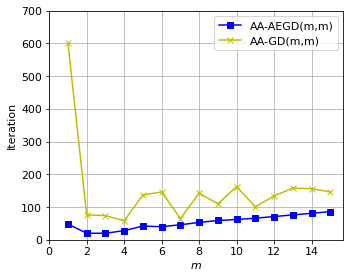

In [14]:
plt.figure(1, figsize=(5,4))

plt.plot(range(1,16), iter_aaegd_m_2, marker='s', linestyle='-', color='b', label='AA-AEGD(m,m)')
plt.plot(range(1,16), iter_aagd_m_2, marker='x', linestyle='-', color='y', label='AA-GD(m,m)')

plt.rcParams.update({'font.size': 11})
plt.yscale('linear')
plt.xscale('linear')
plt.ylim([0,700])
plt.xlabel('$m$')
plt.xticks(range(0,15,2))
plt.ylabel('Iteration')
plt.grid()
plt.legend(loc=0, prop={'size': 11})

plt.tight_layout()
plt.savefig('plot/rosen_m.png', dpi=300)